#### Predictive Analaytics: Harga Cardano melalui Time Series Forecasting

Dataset Source: https://www.bitget.com/price/cardano/historical-data#download


Predictive Analysis Time Series Forecasting

## 1. Pendahuluan

### Deskripsi Proyek
Proyek ini bertujuan untuk mengembangkan model machine learning agar bisa membantu memprediksi harga cardano sesuai dengan analisa. 

Notebook ini berisi implementasi tiga model untuk memprediksi harga Cardano:
- Facebook Prophet (model statistik berbasis dekomposisi)
- XGBoost (model berbasis tree ensemble)
- LSTM (model deep learning untuk sequence data)


## 2. Import Library 
Di bagian ini, kita mengimport library yang diperlukan

In [3]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler


## 3. Data Understanding
Data Understanding merupakan proses memahami informasi dalam data tersebut.

### 3.1 Data Loading


<br>


**Informasi Datasets**


| Jenis | Keterangan |
| ------ | ------ |
| Title | Cardano Price History |
| Source | [Bitget](https://www.bitget.com/price/cardano/historical-data#download) |

In [4]:
df = pd.read_csv('cardano.csv')

## 3.2. Exploratory Data Analysis

Exploratory Data Analysis adalah proses investigasi awal untuk melakukan analisis dari data secara karakteristik, pola, outlier, dan asumsi pada data.

### 3.2.1 EDA - Deskripsi Variabel 

In [5]:
df

,timeOpen,timeClose,timeHigh,timeLow,priceOpen,priceHigh,priceLow,priceClose,volume
0,1747656000000,1747742399999,1747656600000,1747681260000,0.760599,0.763233,0.712015,0.743063,8.702079e+08
1,1747569600000,1747655999999,1747626900000,1747642680000,0.742385,0.775247,0.724618,0.760626,9.405091e+08
2,1747483200000,1747569599999,1747510140000,1747543740000,0.759268,0.780276,0.729465,0.742385,9.745617e+08
3,1747396800000,1747483199999,1747417620000,1747479180000,0.761273,0.784979,0.752905,0.759268,7.619620e+08
4,1747310400000,1747396799999,1747313580000,1747363380000,0.799527,0.809685,0.746850,0.761243,1.282601e+09
...,...,...,...,...,...,...,...,...,...
2441,1535284800000,1535371199999,1535285948000,1535306951000,0.094262,0.094625,0.091405,0.093338,2.690740e+07
2442,1535198400000,1535284799999,1535283245000,1535226549000,0.094305,0.095007,0.092350,0.094282,3.067470e+07
2443,1535112000000,1535198399999,1535192957000,1535117651000,0.092846,0.094363,0.090948,0.094077,3.530240e+07
2444,1535025600000,1535111999999,1535105957000,1535042951000,0.090205,0.093339,0.089165,0.092453,3.739740e+07


In [6]:
df

,timeOpen,timeClose,timeHigh,timeLow,priceOpen,priceHigh,priceLow,priceClose,volume
0,1747656000000,1747742399999,1747656600000,1747681260000,0.760599,0.763233,0.712015,0.743063,8.702079e+08
1,1747569600000,1747655999999,1747626900000,1747642680000,0.742385,0.775247,0.724618,0.760626,9.405091e+08
2,1747483200000,1747569599999,1747510140000,1747543740000,0.759268,0.780276,0.729465,0.742385,9.745617e+08
3,1747396800000,1747483199999,1747417620000,1747479180000,0.761273,0.784979,0.752905,0.759268,7.619620e+08
4,1747310400000,1747396799999,1747313580000,1747363380000,0.799527,0.809685,0.746850,0.761243,1.282601e+09
...,...,...,...,...,...,...,...,...,...
2441,1535284800000,1535371199999,1535285948000,1535306951000,0.094262,0.094625,0.091405,0.093338,2.690740e+07
2442,1535198400000,1535284799999,1535283245000,1535226549000,0.094305,0.095007,0.092350,0.094282,3.067470e+07
2443,1535112000000,1535198399999,1535192957000,1535117651000,0.092846,0.094363,0.090948,0.094077,3.530240e+07
2444,1535025600000,1535111999999,1535105957000,1535042951000,0.090205,0.093339,0.089165,0.092453,3.739740e+07


Dataset berisi 9 variabel utama:

| Variabel | Deskripsi | Tipe Data |
|----------|-----------|-----------|
| **timeOpen** | Timestamp Unix (milidetik) awal periode | int64 |
| **timeClose** | Timestamp Unix (milidetik) akhir periode | int64 |
| **timeHigh** | Timestamp saat harga tertinggi | int64 |
| **timeLow** | Timestamp saat harga terendah | int64 |
| **priceOpen** | Harga pembukaan Cardano (USD) | float64 |
| **priceHigh** | Harga tertinggi Cardano (USD) | float64 |
| **priceLow** | Harga terendah Cardano (USD) | float64 |
| **priceClose** | Harga penutupan Cardano (USD) | float64 |
| **volume** | Volume perdagangan Cardano | float64 |

In [7]:
# Urutkan data berdasarkan tanggal untuk analisis time series
df = df.sort_values('dateOpen')

# Tambahkan fitur turunan untuk analisis
df['day'] = df['dateOpen'].dt.date
df['volatility'] = df['priceHigh'] - df['priceLow']  # Volatilitas harian
df['returnPercentage'] = df['priceClose'].pct_change() * 100  # Return harian dalam persen
df['range_percent'] = (df['priceHigh'] - df['priceLow']) / df['priceOpen'] * 100  # Range harian dalam persen

# Tampilkan statistik deskriptif
print(f"Dataset data range  {df['dateOpen'].min()} to {df['dateClose'].max()}")
print(f"Total data points: {df.shape[0]} daily records")
print(f"Date coverage: {(df['dateClose'].max() - df['dateOpen'].min()).days + 1} days")


# Statistik harga dan volume
print(f"Harga Terendah: {df['priceLow'].min():,.2f} USD / {df['priceLow'].min() * 16410:,.2f} IDR")
print(f"Harga Tertinggi: {df['priceHigh'].max():,.2f} USD / {df['priceHigh'].max() * 16410:,.2f} IDR")
print(f"Volatilitas Tertinggi: {df['volatility'].max():,.2f} USD")
print(f"Return Tertinggi: {df['returnPercentage'].max():,.2f}%")
print(f"Return Terendah: {df['returnPercentage'].min():,.2f}%")

KeyError: 'dateOpen'

In [ ]:
# Hitung Missing Values dan Duplicates
print("\nMissing Values:")
print(df.isnull().sum())
print("\nDuplicates:")
print(df.duplicated().sum())



Missing Values:
timeOpen            0
timeClose           0
timeHigh            0
timeLow             0
priceOpen           0
priceHigh           0
priceLow            0
priceClose          0
volume              0
dateOpen            0
dateClose           0
dateHigh            0
dateLow             0
day                 0
volatility          0
returnPercentage    1
range_percent       0
dtype: int64

Duplicates:
0


### 3.2.2 Menangani Missing Values dan Duplicates

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from matplotlib.ticker import FuncFormatter

# Set visualization style and size
plt.style.use('seaborn-v0_8-darkgrid')
sns.set(font_scale=1.1)
plt.rcParams['figure.figsize'] = (12, 7)

# Sort by date for proper time series analysis
df = df.sort_values('dateOpen')

# Add helpful features
df['day'] = df['dateOpen'].dt.date
df['volatility'] = df['priceHigh'] - df['priceLow']  # Daily volatilitas
df['returnPercentage'] = df['priceClose'].pct_change() * 100   # Daily return dalam bentuk persentase
df['range_percent'] = (df['priceHigh'] - df['priceLow']) / df['priceOpen'] * 100  # Daily range in percentage

In [ ]:
df = df.dropna() # Menghapus baris dengan missing values
print (f"\nTotal rows after dropping missing values: {df.shape[0]}")
print(f"Total missing values: {df.isnull().sum()}")



Total rows after dropping missing values: 2445
Total missing values: timeOpen            0
timeClose           0
timeHigh            0
timeLow             0
priceOpen           0
priceHigh           0
priceLow            0
priceClose          0
volume              0
dateOpen            0
dateClose           0
dateHigh            0
dateLow             0
day                 0
volatility          0
returnPercentage    0
range_percent       0
dtype: int64


#### 3.2.3 Visualisasi Data Harga dan Tren

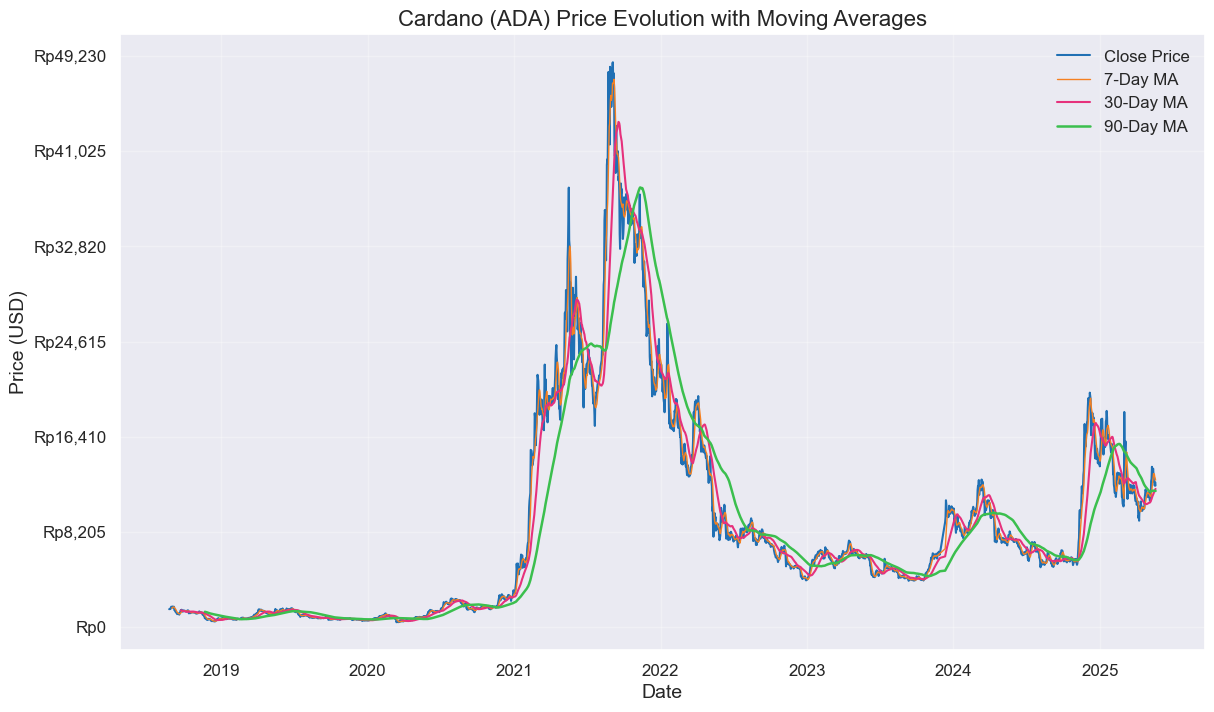

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(df['dateOpen'], df['priceClose'], label='Close Price', color='#2070b4', linewidth=1.5)

# Add moving averages
df['MA_7'] = df['priceClose'].rolling(window=7).mean()
df['MA_30'] = df['priceClose'].rolling(window=30).mean()
df['MA_90'] = df['priceClose'].rolling(window=90).mean()

plt.plot(df['dateOpen'], df['MA_7'], label='7-Day MA', color='#f58021', linewidth=1)
plt.plot(df['dateOpen'], df['MA_30'], label='30-Day MA', color='#e6317c', linewidth=1.5)
plt.plot(df['dateOpen'], df['MA_90'], label='90-Day MA', color='#3bbf4e', linewidth=1.8)

plt.title('Cardano (ADA) Price Evolution with Moving Averages', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Conversion rate from USD to IDR (example rate, update as needed)
usd_to_idr = 16410  # (Updated 20 Mei 2025)

# Format y-axis to show Rupiah amounts
def rupiah_format(x, pos):
    # Convert to IDR then format
    x_idr = x * usd_to_idr
    return f'Rp{x_idr:,.0f}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(rupiah_format))
plt.show()

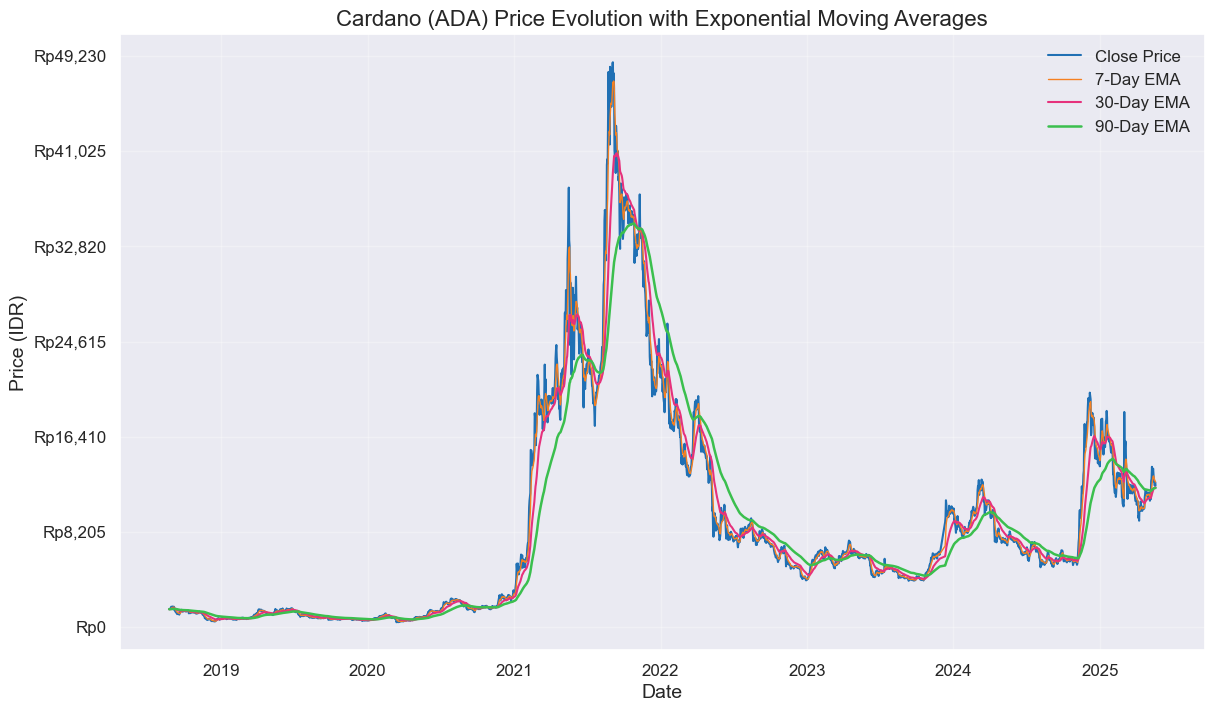

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(df['dateOpen'], df['priceClose'], label='Close Price', color='#2070b4', linewidth=1.5)

# Add Exponential Moving Averages (EMA) (lebih responsif terhadap perubahan harga)
df['EMA_7'] = df['priceClose'].ewm(span=7, adjust=False).mean()
df['EMA_30'] = df['priceClose'].ewm(span=30, adjust=False).mean()
df['EMA_90'] = df['priceClose'].ewm(span=90, adjust=False).mean()

plt.plot(df['dateOpen'], df['EMA_7'], label='7-Day EMA', color='#f58021', linewidth=1)
plt.plot(df['dateOpen'], df['EMA_30'], label='30-Day EMA', color='#e6317c', linewidth=1.5)
plt.plot(df['dateOpen'], df['EMA_90'], label='90-Day EMA', color='#3bbf4e', linewidth=1.8)

plt.title('Cardano (ADA) Price Evolution with Exponential Moving Averages', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (IDR)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Conversion rate from USD to IDR (example rate, update as needed)
usd_to_idr = 16410  # (Updated 20 Mei 2025)

# Format y-axis to show Rupiah amounts
def rupiah_format(x, pos):
    # Convert to IDR then format
    x_idr = x * usd_to_idr
    return f'Rp{x_idr:,.0f}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(rupiah_format))
plt.show()

#### 4. DATA PREPARATION

In [8]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Split data into training (80%) and testing (20%) sets
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Feature engineering
# Lakukan feature engineering pada seluruh dataset (df telah di-load sebelumnya)
df['MA_7'] = df['priceClose'].rolling(window=7).mean()
df['MA_30'] = df['priceClose'].rolling(window=30).mean()
df['EMA_7'] = df['priceClose'].ewm(span=7, adjust=False).mean()
df['volatility'] = df['priceHigh'] - df['priceLow']
df['volume_change'] = df['volume'].pct_change()
df['price_change'] = df['priceClose'].pct_change()

# Scale the data for neural networks
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['priceClose'].values.reshape(-1, 1))

In [9]:


# Convert Unix timestamps (milliseconds) to datetime format
df['dateOpen'] = pd.to_datetime(df['timeOpen'], unit='ms')
df['dateClose'] = pd.to_datetime(df['timeClose'], unit='ms')
df['dateHigh'] = pd.to_datetime(df['timeHigh'], unit='ms')
df['dateLow'] = pd.to_datetime(df['timeLow'], unit='ms')

# Display basic info
print("DataFrame shape:", df.shape)
print("\nColumn names:", df.columns.tolist())
print("\nDate range:", df['dateOpen'].min(), "to", df['dateOpen'].max())

DataFrame shape: (2446, 19)

Column names: ['timeOpen', 'timeClose', 'timeHigh', 'timeLow', 'priceOpen', 'priceHigh', 'priceLow', 'priceClose', 'volume', 'MA_7', 'MA_30', 'EMA_7', 'volatility', 'volume_change', 'price_change', 'dateOpen', 'dateClose', 'dateHigh', 'dateLow']

Date range: 2018-08-22 12:00:00 to 2025-05-19 12:00:00


#### 5. Modelling

### Prophet Model

In [40]:
# pip install prophet


In [ ]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')  # Suppress prophet warnings

# Prepare data for Prophet - Add log transformation to stabilize variance
prophet_df = pd.DataFrame({
    'ds': df['dateOpen'],
    'y': np.log(df['priceClose'])  # Log transform to stabilize volatility
})

# Add market indicators as regressors
prophet_df['price_momentum'] = prophet_df['y'].diff().rolling(window=7).mean()
prophet_df['volatility'] = prophet_df['y'].diff().rolling(window=7).std()
prophet_df['volume_norm'] = (df['volume'] / df['volume'].rolling(window=30).mean()).values

# Fill any NaNs from lagged features
prophet_df = prophet_df.fillna(method='bfill')

# Split data into training (80%) and testing (20%) sets
train_size = int(len(prophet_df) * 0.8)
train_df = prophet_df.iloc[:train_size]
test_df = prophet_df.iloc[train_size:]

# Create a more flexible model with better parameters for cryptocurrency
prophet_model = Prophet(
    daily_seasonality=False,  # No daily seasonality in crypto
    weekly_seasonality=True,  # Weekly patterns are common in crypto
    yearly_seasonality=False,  # Override annual patterns (not relevant for shorter crypto history)
    changepoint_prior_scale=0.15,  # More flexible trend changes
    seasonality_prior_scale=1.0,   # Less emphasis on seasonality
    seasonality_mode='multiplicative',  # Better for volatile data
    changepoint_range=0.95,  # Allow changepoints almost to the end of training data
    mcmc_samples=0  # Faster fitting
)

# Add weekly seasonality with a more flexible setting
prophet_model.add_seasonality(
    name='weekly',
    period=7,
    fourier_order=5,  # More complex weekly patterns
    mode='multiplicative'
)

# Add custom monthly seasonality (crypto often has monthly patterns)
prophet_model.add_seasonality(
    name='monthly',
    period=30.5,
    fourier_order=5,
    mode='multiplicative'
)

19:22:25 - cmdstanpy - INFO - Chain [1] start processing
19:22:27 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model Results - MAE: 0.6803, RMSE: 0.7214, Accuracy: -1059.32%


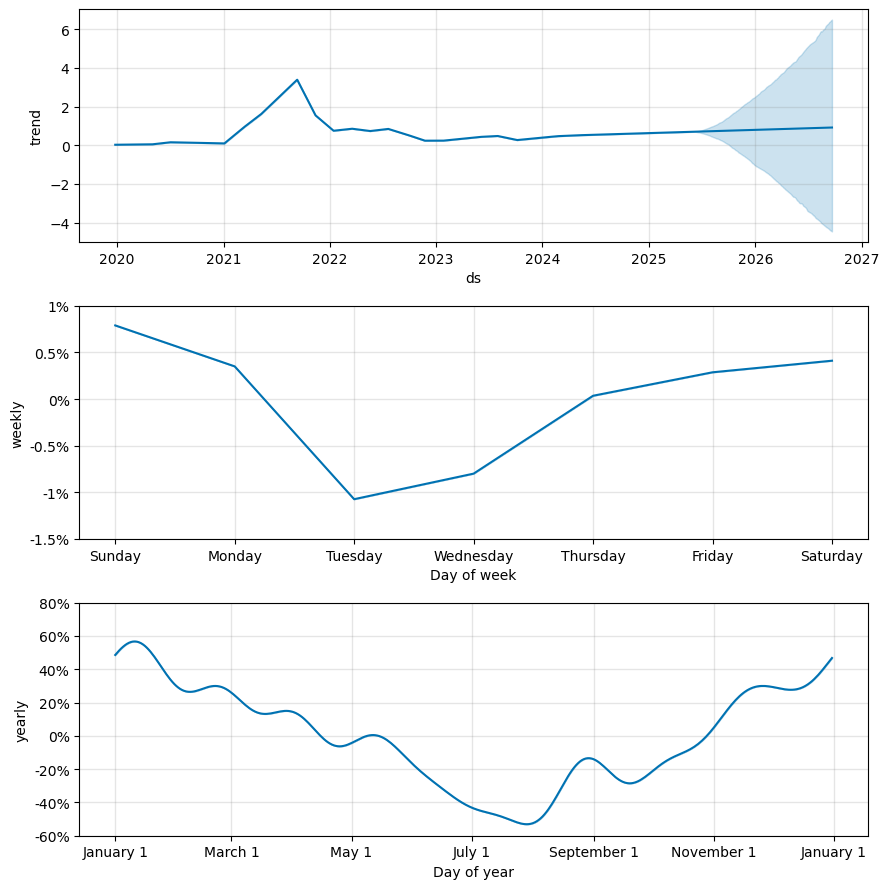

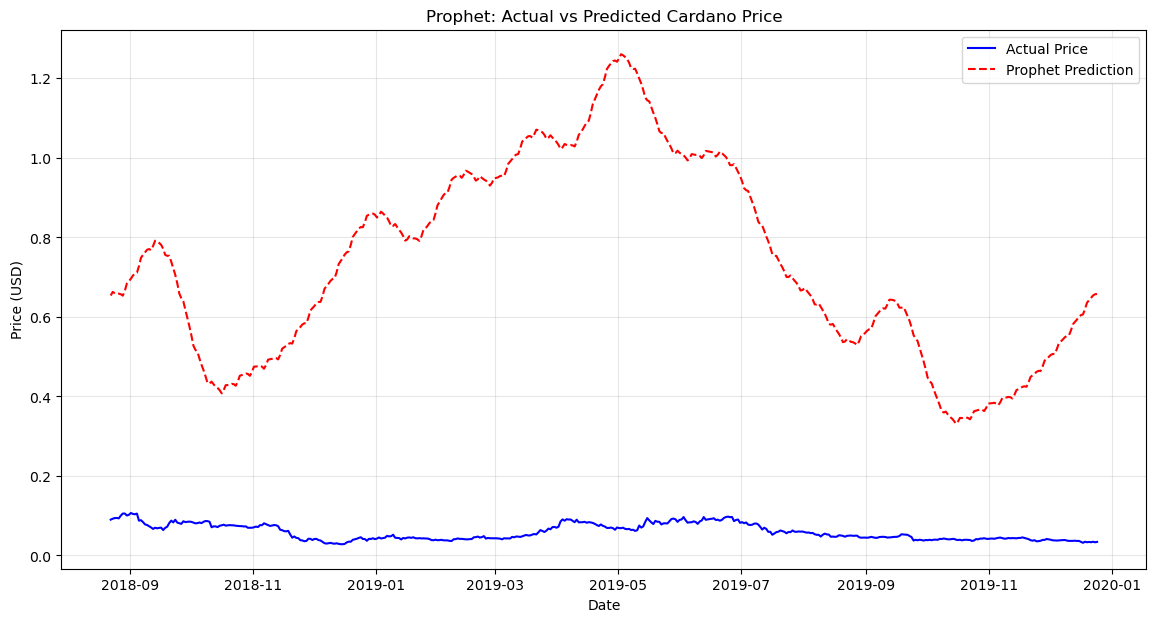

In [13]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Siapkan data Prophet (memerlukan kolom 'ds' dan 'y')
prophet_df = pd.DataFrame({
    'ds': df['dateOpen'],
    'y': df['priceClose']
})

# Split data menjadi training (80%) dan testing (20%)
train_size = int(len(prophet_df) * 0.8)
train_df = prophet_df.iloc[:train_size]
test_df = prophet_df.iloc[train_size:]

# Buat dan fit model Prophet
# More flexible model with higher changepoint_prior_scale
prophet_model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True, 
    yearly_seasonality=True,
    changepoint_prior_scale=0.5,  # Increased from 0.05
    seasonality_prior_scale=5.0,  # Decreased from 10.0
    seasonality_mode='multiplicative'  # Better for volatile data
)
prophet_model.fit(train_df)

# Buat future dataframe untuk periode test
# Gunakan jumlah periode sama dengan jumlah baris pada test_df
future = prophet_model.make_future_dataframe(periods=len(test_df), freq='D')
forecast = prophet_model.predict(future)

# Ekstrak prediksi untuk periode test (ambil tail forecast)
prophet_preds = forecast.tail(len(test_df))['yhat'].values

# Evaluasi model Prophet
prophet_mae = mean_absolute_error(test_df['y'], prophet_preds)
prophet_rmse = np.sqrt(mean_squared_error(test_df['y'], prophet_preds))
accuracy = 100 - (prophet_mae / test_df['y'].mean() * 100)
print(f"Prophet Model Results - MAE: {prophet_mae:.4f}, RMSE: {prophet_rmse:.4f}, Accuracy: {accuracy:.2f}%")

# Plot komponen forecast (trend, musiman mingguan, dan musiman tahunan)
fig = prophet_model.plot_components(forecast)
plt.show()

# Plot perbandingan nilai aktual vs prediksi
# Gunakan kolom 'ds' dari test_df sebagai tanggal aktual
plt.figure(figsize=(14, 7))
plt.plot(test_df['ds'], test_df['y'], label='Actual Price', color='blue')
plt.plot(test_df['ds'], prophet_preds, label='Prophet Prediction', color='red', linestyle='--')
plt.title('Prophet: Actual vs Predicted Cardano Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

XGBoost Model Results - MAE: 0.0265, RMSE: 0.0469, Accuracy: 95.59%


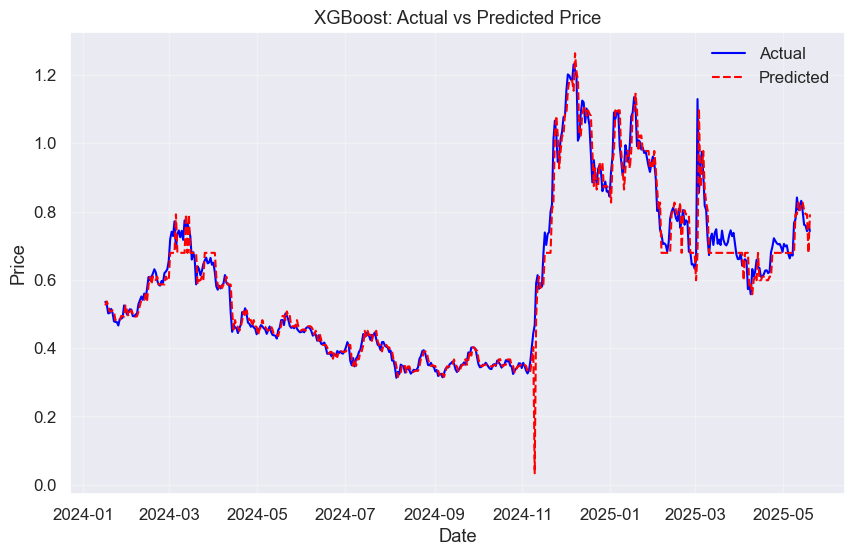

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

X_train = train_data[['priceOpen']]
y_train = train_data['priceClose']
X_test  = test_data[['priceOpen']]
y_test  = test_data['priceClose']

# Buat dan fit model XGBoost
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# Forecast pada test set
xgb_preds = xgb_model.predict(X_test)

# Evaluasi model XGBoost
xgb_mae  = mean_absolute_error(y_test, xgb_preds)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
accuracy = 100 - (xgb_mae / y_test.mean() * 100)
print(f"XGBoost Model Results - MAE: {xgb_mae:.4f}, RMSE: {xgb_rmse:.4f}, Accuracy: {accuracy:.2f}%")

# Plot perbandingan nilai aktual vs prediksi
plt.figure(figsize=(10,6))
plt.plot(test_data['dateOpen'], y_test, label='Actual', color='blue')
plt.plot(test_data['dateOpen'], xgb_preds, label='Predicted', color='red', linestyle='--')
plt.title("XGBoost: Actual vs Predicted Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler

# Lakukan seed setting untuk konsistensi
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    # Configure TensorFlow for deterministic operations
    tf.config.experimental.enable_op_determinism()
    
set_seeds(42)

# Data preparation
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Prepare data for LSTM
sequence_length = 60  # Use 60 days of historical data to predict the next day

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_price = scaler.fit_transform(df['priceClose'].values.reshape(-1, 1))

# Create sequences
X, y = create_sequences(scaled_price, sequence_length)

# Split into training and testing sets
print(f"Using existing train-test split:")
print(f"Train data: {len(train_data)} samples")
print(f"Test data: {len(test_data)} samples")

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

# Buat LSTM Model
def create_lstm_model(sequence_length):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(units=1)
    ])
    
    # Use consistent optimizer configuration
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07
    )
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Create model
lstm_model = create_lstm_model(sequence_length)

lstm_model.compile(optimizer='adam', loss='mean_squared_error')


# Train LSTM model with early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=15, 
    restore_best_weights=True,
    verbose=1
)
print("\nTraining LSTM Model...")
history = lstm_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Make predictions
lstm_preds = lstm_model.predict(X_test)
# Inverse transform predictions and actual values
lstm_preds_scaled = scaler.inverse_transform(lstm_preds)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate LSTM model
lstm_mae = mean_absolute_error(y_test_scaled, lstm_preds_scaled)
lstm_rmse = np.sqrt(mean_squared_error(y_test_scaled, lstm_preds_scaled))
lstm_accuracy = 100 - (lstm_mae / np.mean(y_test_scaled) * 100)


print(f"LSTM Model Results - MAE: {lstm_mae:.4f}, RMSE: {lstm_rmse:.4f}, Accuracy: {100 - (lstm_mae / y_test_inv.mean() * 100):.2f}%")

Using existing train-test split:
Train data: 1956 samples
Test data: 489 samples
Training samples: 1908, Testing samples: 477

Training LSTM Model...
Epoch 1/100


c:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0233 - val_loss: 1.7569e-04
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0021 - val_loss: 1.8601e-04
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0021 - val_loss: 1.8879e-04
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0019 - val_loss: 1.9520e-04
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0017 - val_loss: 1.1806e-04
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0016 - val_loss: 1.2093e-04
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0014 - val_loss: 1.1905e-04
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0016 - val_loss: 1.0869e-04
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0015 - val_loss: 3.9521e-04
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0019 - val_loss: 1.0436e-04
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0016 - val_loss: 9.8790e-05
Epoch 12/100
48/48 ━

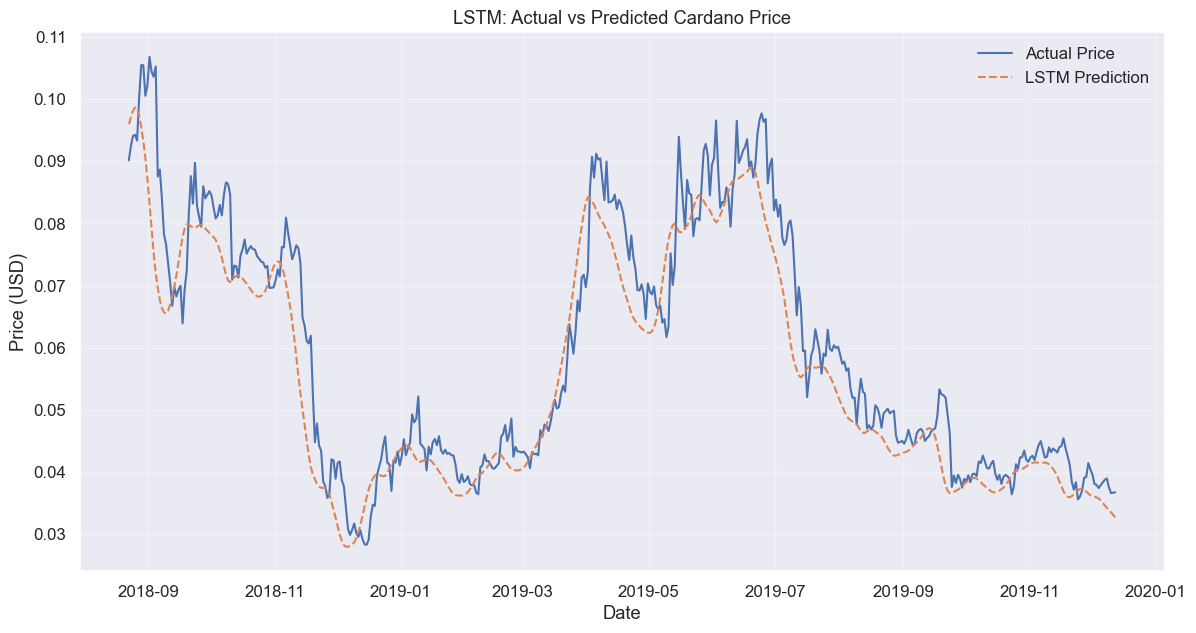

In [ ]:

# Plot actual vs predicted values
test_dates = df['dateOpen'].iloc[train_size + sequence_length:train_size + sequence_length + len(y_test)]
plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test_inv, label='Actual Price')
plt.plot(test_dates, lstm_preds, label='LSTM Prediction', linestyle='--')
plt.title('LSTM: Actual vs Predicted Cardano Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()